### Big Data Mart Sales Problem
Problem Statement:
The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and find out the sales of each product at a particular store.

Using this model, BigMart will try to understand the properties of products and stores which play a key role in increasing the sales of their products.

The dataset includes two files:

- bigdatamart_Train.csv: Use this file for the model building purpose. 

- bigdatamart_Test.csv: Use this file for getting predictions from the trained model. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression,Lasso,LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.decomposition import PCA
from scipy.stats import zscore
from sklearn.model_selection import cross_val_score
import pickle as pkl

In [2]:
df1= pd.read_csv('https://raw.githubusercontent.com/dsrscientist/bigdatamart_rep/master/bigdatamart_Train.csv')
df2= pd.read_csv('https://raw.githubusercontent.com/dsrscientist/bigdatamart_rep/master/bigdatamart_Test.csv')
df = pd.concat([df1,df2]).reset_index(drop=True)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
display(df.head())

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0  FDA15           9.30         Low Fat          0.016047          
1  DRC01           5.92         Regular          0.019278          
2  FDN15           17.50        Low Fat          0.016760          
3  FDX07           19.20        Regular          0.000000          
4  NCD19           8.93         Low Fat          0.000000          

               Item_Type  Item_MRP Outlet_Identifier  \
0  Dairy                  249.8092  OUT049             
1  Soft Drinks            48.2692   OUT018             
2  Meat                   141.6180  OUT049             
3  Fruits and Vegetables  182.0950  OUT010             
4  Household              53.8614   OUT013             

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0  1999                       Medium      Tier 1                
1  2009                       Medium      Tier 3                
2  1999                       Medium      Tier 1                
3  1998                       NaN         Tier 3                
4  1987                       High        Tier 3                

         Outlet_Type  Item_Outlet_Sales  
0  Supermarket Type1  3735.1380          
1  Supermarket Type2  443.4228           
2  Supermarket Type1  2097.2700          
3  Grocery Store      732.3800           
4  Supermarket Type1  994.7052

In [3]:
df = df.drop(['Item_Identifier','Outlet_Identifier'],axis=1)

In [4]:
df.shape

(14204, 10)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14204 entries, 0 to 14203
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                11765 non-null  float64
 1   Item_Fat_Content           14204 non-null  object 
 2   Item_Visibility            14204 non-null  float64
 3   Item_Type                  14204 non-null  object 
 4   Item_MRP                   14204 non-null  float64
 5   Outlet_Establishment_Year  14204 non-null  int64  
 6   Outlet_Size                10188 non-null  object 
 7   Outlet_Location_Type       14204 non-null  object 
 8   Outlet_Type                14204 non-null  object 
 9   Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 1.1+ MB


In [6]:
df.select_dtypes(exclude=['object']).columns

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales'],
      dtype='object')

In [7]:
numerical = ['Item_Weight', 'Item_Visibility', 'Item_MRP','Item_Outlet_Sales']

In [8]:
df.select_dtypes(include=['object']).columns

Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type'],
      dtype='object')

In [9]:
categorical = ['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type','Outlet_Establishment_Year']

In [10]:
[i for i in df.columns if df[i].isnull().sum()>0]

['Item_Weight', 'Outlet_Size', 'Item_Outlet_Sales']

In [12]:
df['Outlet_Size'] = df['Outlet_Size'].fillna(df['Outlet_Size'].dropna().mode()[0])

In [14]:
df['Item_Weight'] = df['Item_Weight'].fillna(df['Item_Weight'].dropna().mean())

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14204 entries, 0 to 14203
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                14204 non-null  float64
 1   Item_Fat_Content           14204 non-null  object 
 2   Item_Visibility            14204 non-null  float64
 3   Item_Type                  14204 non-null  object 
 4   Item_MRP                   14204 non-null  float64
 5   Outlet_Establishment_Year  14204 non-null  int64  
 6   Outlet_Size                14204 non-null  object 
 7   Outlet_Location_Type       14204 non-null  object 
 8   Outlet_Type                14204 non-null  object 
 9   Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 1.1+ MB


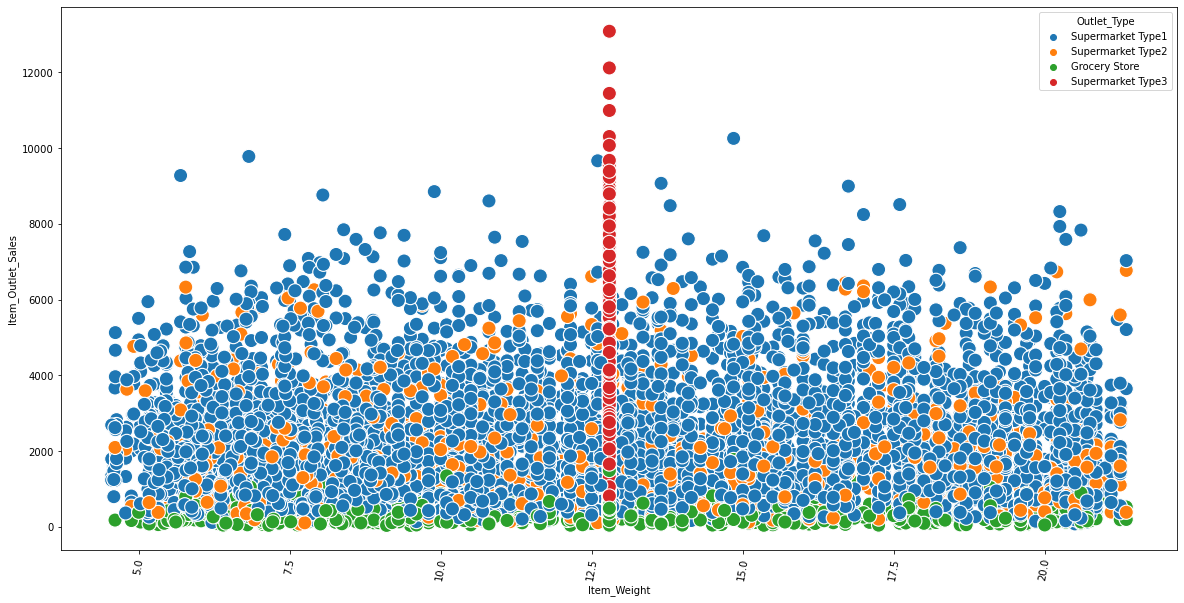

In [40]:
plt.figure(figsize=(20,10))
sns.scatterplot(x="Item_Weight", y="Item_Outlet_Sales",hue='Outlet_Type',data=df,s=200)
plt.xticks(rotation=80)
plt.show()

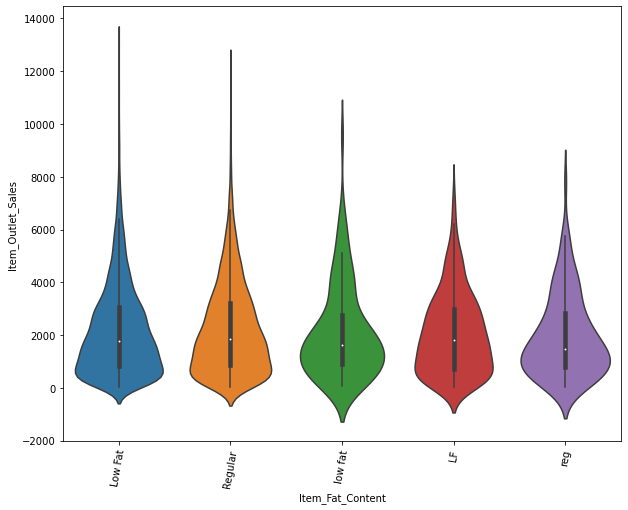

In [25]:
plt.figure(figsize=(10,8))
sns.violinplot(x="Item_Fat_Content", y="Item_Outlet_Sales", data=df1)
plt.xticks(rotation=80)
plt.show()

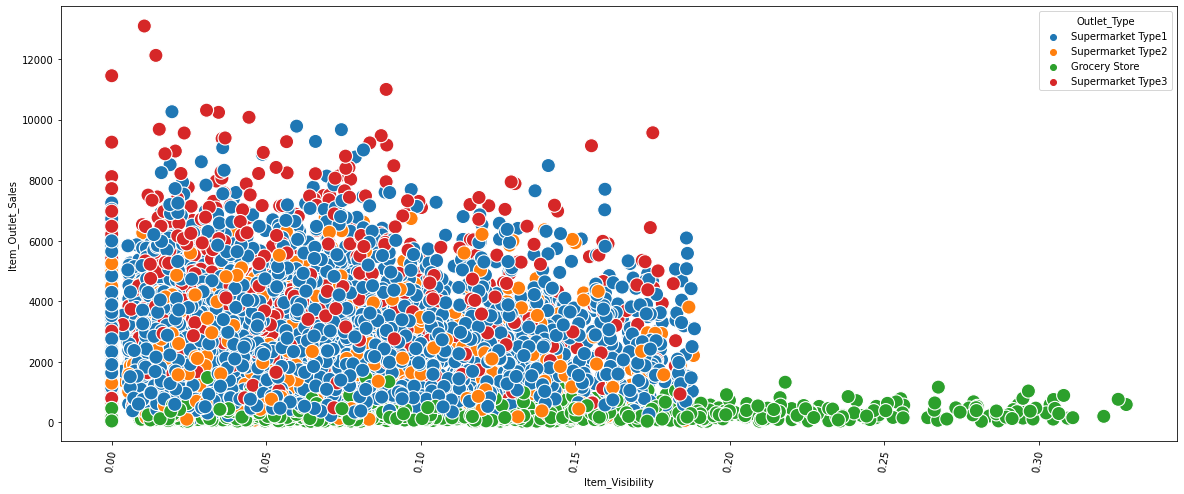

In [38]:
plt.figure(figsize=(20,8))
sns.scatterplot(x="Item_Visibility", y="Item_Outlet_Sales",hue='Outlet_Type',data=df,s=200)
plt.xticks(rotation=80)
plt.show()

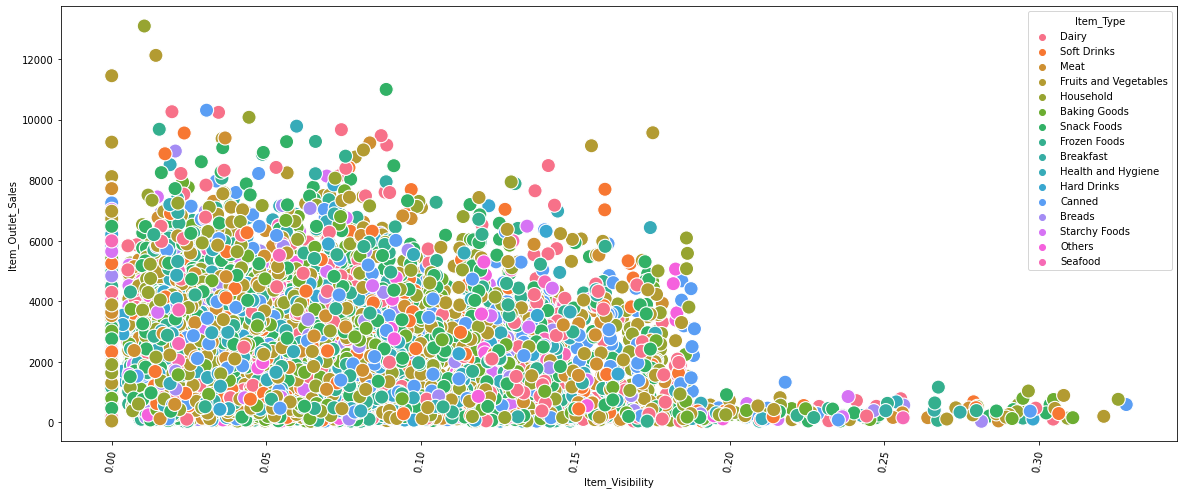

In [41]:
plt.figure(figsize=(20,8))
sns.scatterplot(x="Item_Visibility", y="Item_Outlet_Sales",hue='Item_Type',data=df,s=200)
plt.xticks(rotation=80)
plt.show()

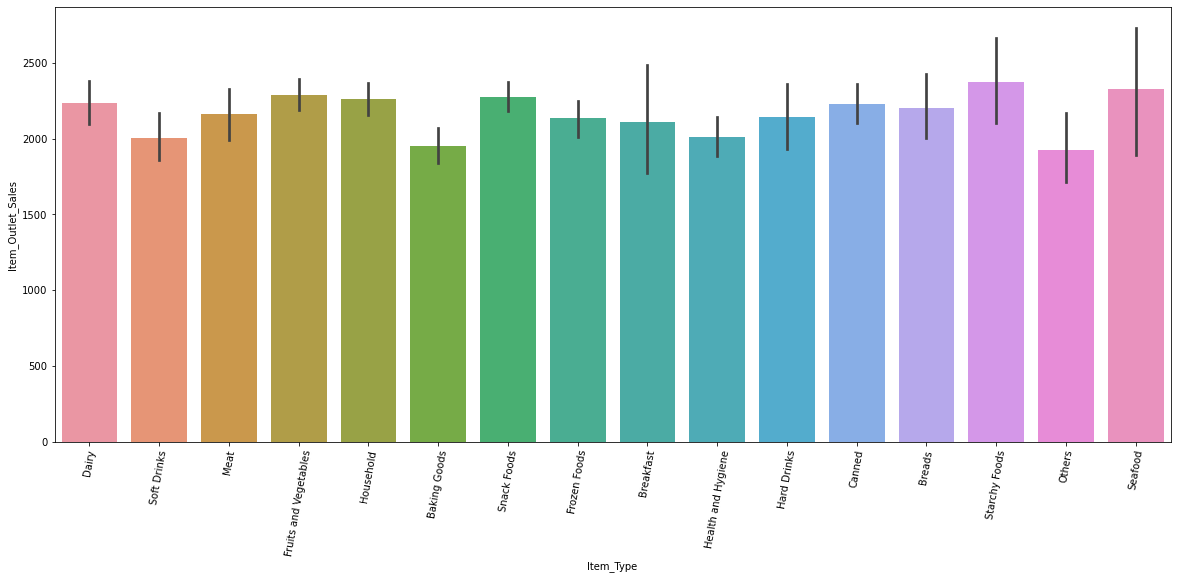

In [45]:
plt.figure(figsize=(20,8))
sns.barplot(x="Item_Type", y="Item_Outlet_Sales",data=df)
plt.xticks(rotation=80)
plt.show()

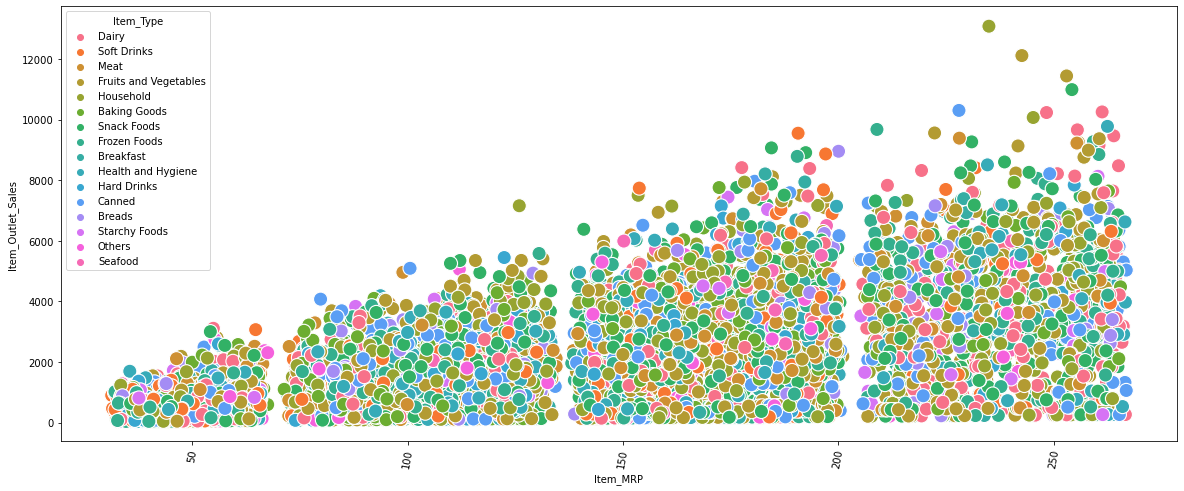

In [48]:
plt.figure(figsize=(20,8))
sns.scatterplot(x="Item_MRP", y="Item_Outlet_Sales",data=df,hue='Item_Type',s=200)
plt.xticks(rotation=80)
plt.show()

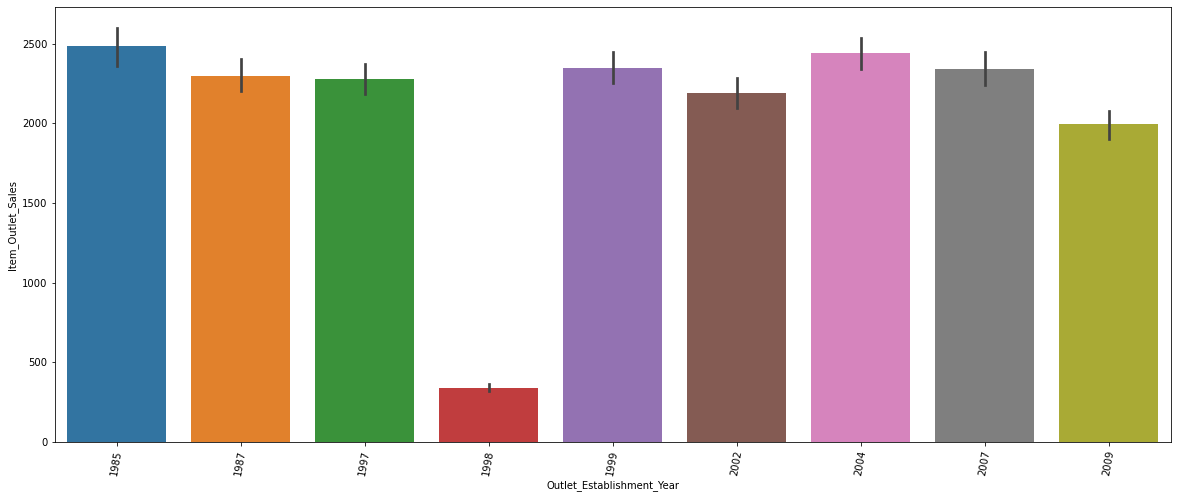

In [49]:
plt.figure(figsize=(20,8))
sns.barplot(x="Outlet_Establishment_Year", y="Item_Outlet_Sales",data=df)
plt.xticks(rotation=80)
plt.show()

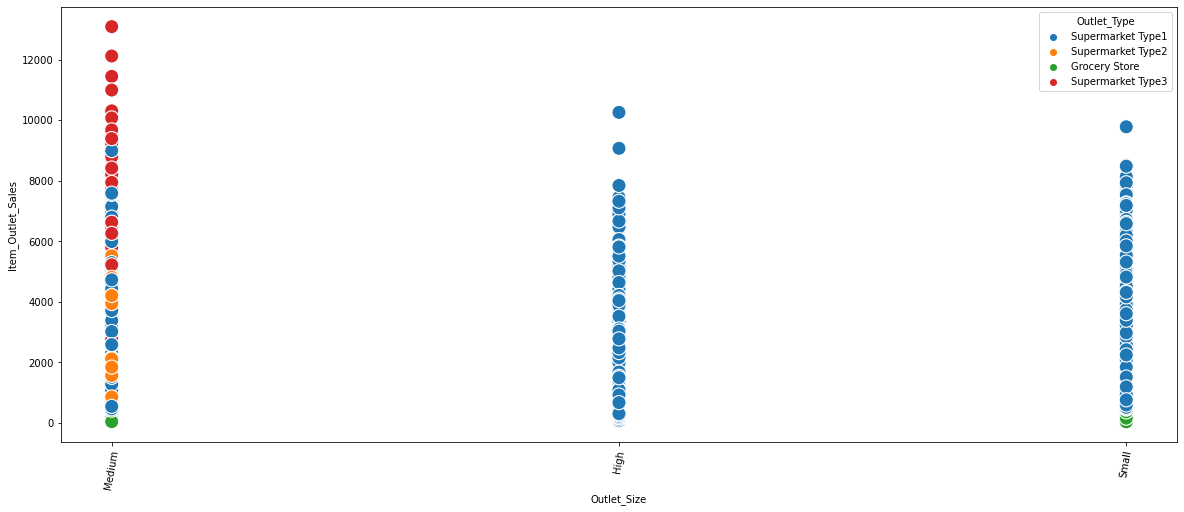

In [52]:
plt.figure(figsize=(20,8))
sns.scatterplot(x="Outlet_Size", y="Item_Outlet_Sales",data=df,hue='Outlet_Type',s=200)
plt.xticks(rotation=80)
plt.show()

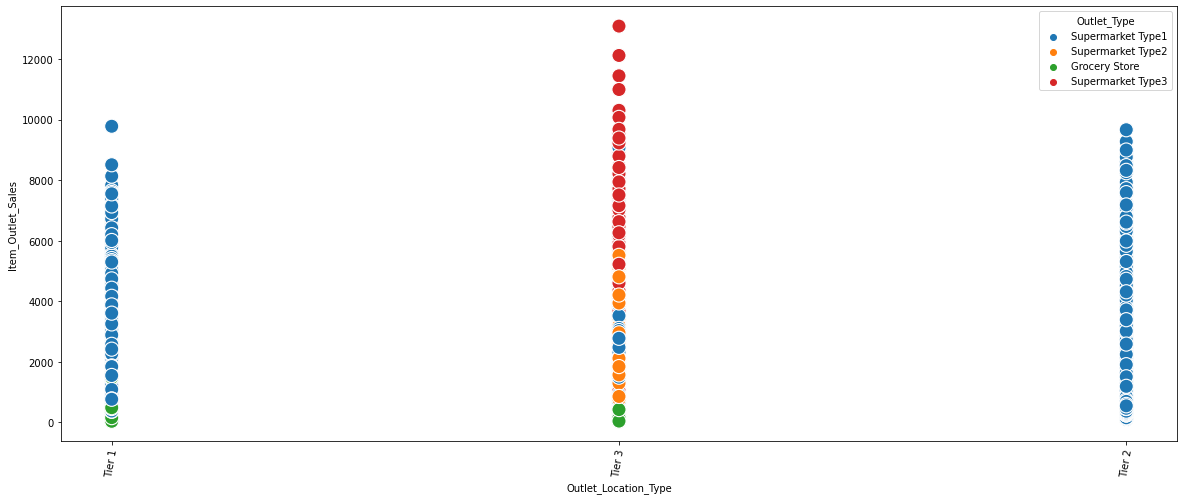

In [53]:
plt.figure(figsize=(20,8))
sns.scatterplot(x="Outlet_Location_Type", y="Item_Outlet_Sales",data=df,hue='Outlet_Type',s=200)
plt.xticks(rotation=80)
plt.show()

In [55]:
columns =['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type',
       'Item_MRP', 'Outlet_Establishment_Year', 'Outlet_Size',
       'Outlet_Location_Type', 'Outlet_Type', 'Item_Outlet_Sales']

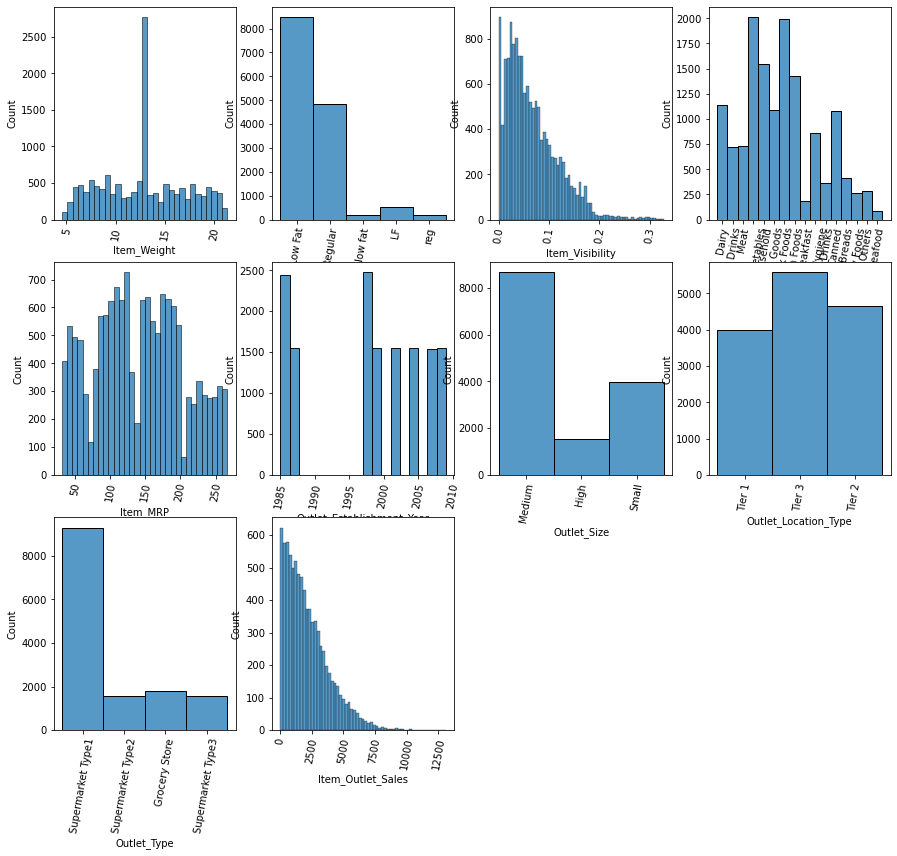

In [59]:
count=1
plt.subplots(figsize=(15,18))
for i in columns:
    plt.subplot(4,4,count)
    sns.histplot(df[i])
    plt.xticks(rotation=80)
    count+=1

plt.show()

In [60]:
lab = LabelEncoder()
for i in categorical:
    df[i] = lab.fit_transform(df[i])

print(df.dtypes)

Item_Weight                  float64
Item_Fat_Content             int32  
Item_Visibility              float64
Item_Type                    int32  
Item_MRP                     float64
Outlet_Establishment_Year    int64  
Outlet_Size                  int32  
Outlet_Location_Type         int32  
Outlet_Type                  int32  
Item_Outlet_Sales            float64
dtype: object


In [61]:
df.corr()

Item_Weight  Item_Fat_Content  Item_Visibility  \
Item_Weight                1.000000    -0.027387         -0.013641          
Item_Fat_Content          -0.027387     1.000000          0.033864          
Item_Visibility           -0.013641     0.033864          1.000000          
Item_Type                  0.028637    -0.121140         -0.035646          
Item_MRP                   0.033002    -0.006195         -0.006351          
Outlet_Establishment_Year  0.000503    -0.002541         -0.091511          
Outlet_Size                0.001580    -0.007084          0.064836          
Outlet_Location_Type      -0.002104    -0.002518         -0.017362          
Outlet_Type                0.001699    -0.002380         -0.165726          
Item_Outlet_Sales          0.011083     0.009800         -0.128625          

                           Item_Type  Item_MRP  Outlet_Establishment_Year  \
Item_Weight                0.028637   0.033002  0.000503                    
Item_Fat_Content          -0.121140  -0.006195 -0.002541                    
Item_Visibility           -0.035646  -0.006351 -0.091511                    
Item_Type                  1.000000   0.043948  0.003295                    
Item_MRP                   0.043948   1.000000  0.000302                    
Outlet_Establishment_Year  0.003295   0.000302  1.000000                    
Outlet_Size               -0.002608  -0.001018  0.070796                    
Outlet_Location_Type       0.002083   0.000838  0.041889                    
Outlet_Type                0.004305   0.000136 -0.040255                    
Item_Outlet_Sales          0.017048   0.567574 -0.025525                    

                           Outlet_Size  Outlet_Location_Type  Outlet_Type  \
Item_Weight                0.001580    -0.002104              0.001699      
Item_Fat_Content          -0.007084    -0.002518             -0.002380      
Item_Visibility            0.064836    -0.017362             -0.165726      
Item_Type                 -0.002608     0.002083              0.004305      
Item_MRP                  -0.001018     0.000838              0.000136      
Outlet_Establishment_Year  0.070796     0.041889             -0.040255      
Outlet_Size                1.000000    -0.614300             -0.201505      
Outlet_Location_Type      -0.614300     1.000000              0.467251      
Outlet_Type               -0.201505     0.467251              1.000000      
Item_Outlet_Sales         -0.086182     0.089367              0.401522      

                           Item_Outlet_Sales  
Item_Weight                0.011083           
Item_Fat_Content           0.009800           
Item_Visibility           -0.128625           
Item_Type                  0.017048           
Item_MRP                   0.567574           
Outlet_Establishment_Year -0.025525           
Outlet_Size               -0.086182           
Outlet_Location_Type       0.089367           
Outlet_Type                0.401522           
Item_Outlet_Sales          1.000000

<AxesSubplot:>

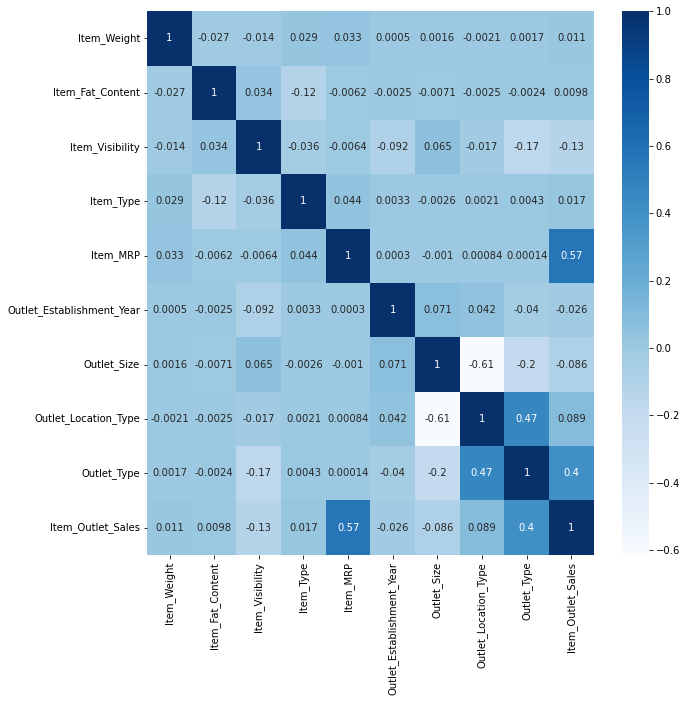

In [62]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),cbar=True,annot=True,cmap='Blues')

In [63]:
df.skew()

Item_Weight                  0.111314
Item_Fat_Content             0.996640
Item_Visibility              1.195175
Item_Type                    0.099574
Item_MRP                     0.130728
Outlet_Establishment_Year    0.034412
Outlet_Size                 -0.087077
Outlet_Location_Type        -0.209053
Outlet_Type                  0.927344
Item_Outlet_Sales            1.177531
dtype: float64

In [64]:
for i in columns :
    if df.skew().loc[i]>0.60:
        df[i] = np.log1p(df[i])

In [65]:
df.skew()

Item_Weight                  0.111314
Item_Fat_Content            -0.331504
Item_Visibility              1.038885
Item_Type                    0.099574
Item_MRP                     0.130728
Outlet_Establishment_Year    0.034412
Outlet_Size                 -0.087077
Outlet_Location_Type        -0.209053
Outlet_Type                 -0.235873
Item_Outlet_Sales           -0.882266
dtype: float64

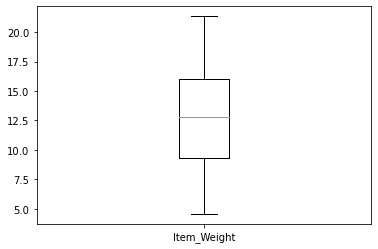

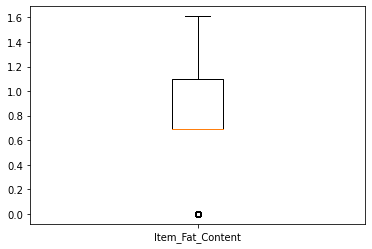

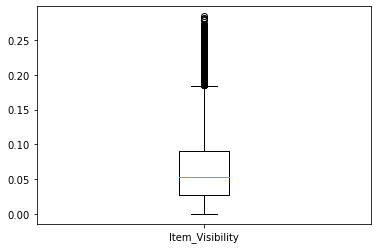

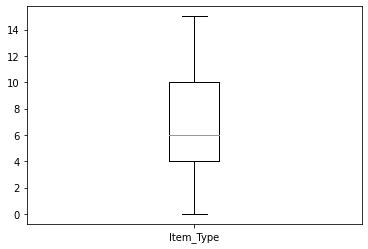

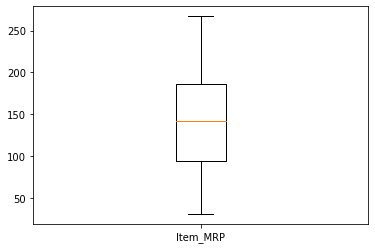

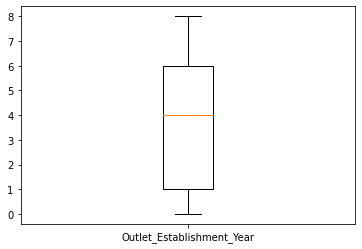

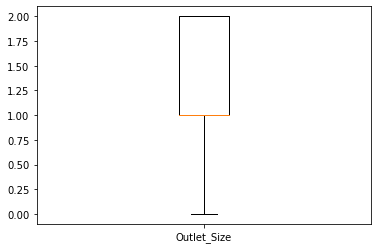

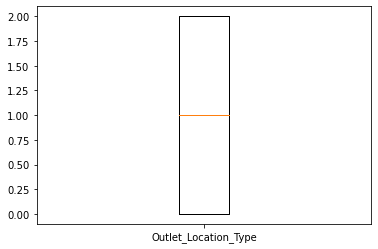

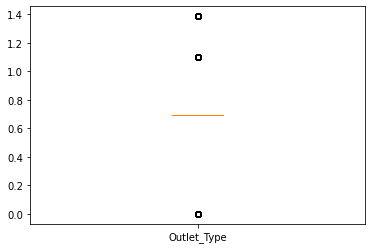

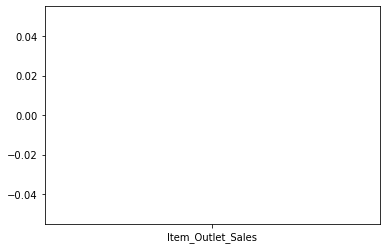

In [66]:
for i in columns:
    plt.boxplot(df[i], labels = [i])
    plt.show()

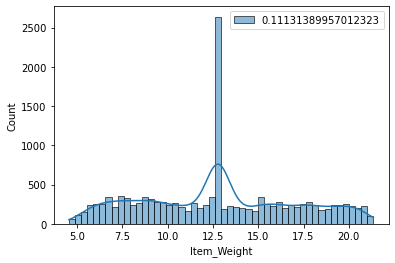

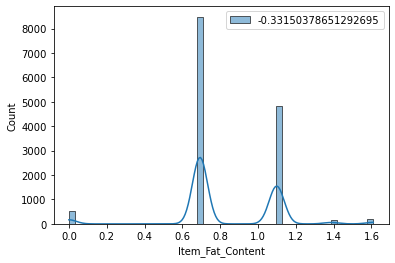

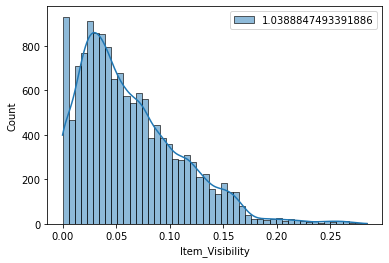

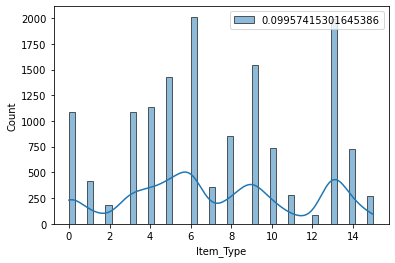

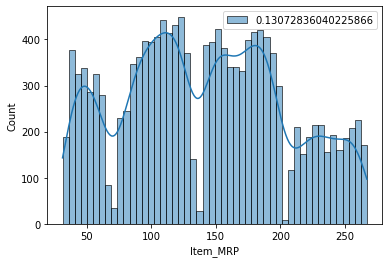

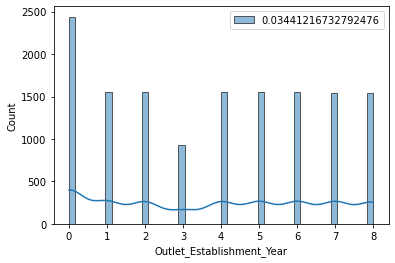

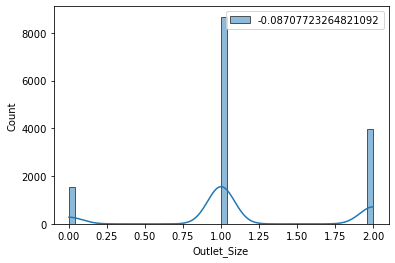

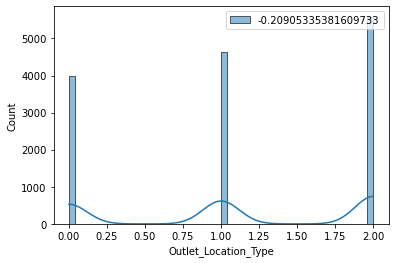

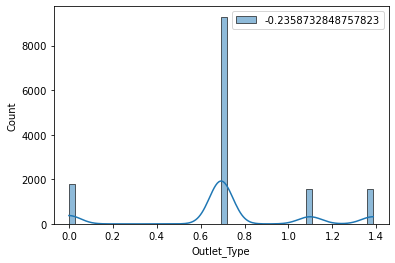

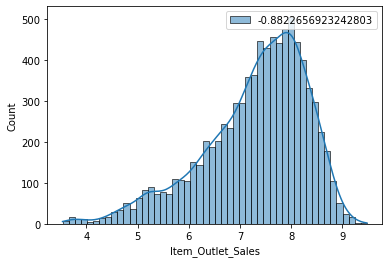

In [67]:
for i in columns:
    sns.histplot(df[i], kde = True, bins = 50, label = df[i].skew())
    plt.legend(loc = 'upper right')
    plt.show()

In [68]:
for i in columns:
    Q1,Q3 = np.percentile(df[i] , [25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    df_no_outliers = df[(df[i] < lower_range) | (df[i] > upper_range)]

In [69]:
df_no_outliers

Empty DataFrame
Columns: [Item_Weight, Item_Fat_Content, Item_Visibility, Item_Type, Item_MRP, Outlet_Establishment_Year, Outlet_Size, Outlet_Location_Type, Outlet_Type, Item_Outlet_Sales]
Index: []

In [70]:
z = np.abs(zscore(df))
threshold = 3
print(np.where(z<3))
print(df.shape)

(array([    0,     0,     0, ..., 14203, 14203, 14203], dtype=int64), array([0, 1, 2, ..., 6, 7, 8], dtype=int64))
(14204, 10)


In [71]:
df_new = df[(z<3).all(axis = 1)]
df_new.shape

(0, 10)

In [72]:
df.shape

(14204, 10)

In [73]:
df1.shape

(8523, 12)

In [74]:
X = df.drop(['Item_Outlet_Sales'],axis=1).iloc[:8522]
y = df['Item_Outlet_Sales'].iloc[:8522]

In [75]:
from sklearn.preprocessing import StandardScaler

In [76]:
for i in X.columns:
    scaler = StandardScaler()
    X[i] = scaler.fit_transform(X[i].values.reshape(-1, 1))

In [77]:
reg_model = [LinearRegression(),GradientBoostingRegressor(),AdaBoostRegressor(),DecisionTreeRegressor(),KNeighborsRegressor(),ExtraTreesRegressor(),RandomForestRegressor()]
max_r2_score = 0
for r_state in range(42,95):
    X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = r_state,test_size = 0.33)
    for i in reg_model:
        i.fit(X_train,y_train)
        pred = i.predict(X_test)
        r2_scores = r2_score(y_test,pred)
        print("R2 score for the random state is" ,r_state ,"is", r2_scores)
        if r2_scores > max_r2_score:
            max_r2_score = r2_scores
            final_state = r_state
            final_model = i
print()
print()
print()
print()
print("Maximum R2 score in the random state " ,final_state , "is" , max_r2_score ,"and model is",final_model)

R2 score for the random state is 42 is 0.6336089428798659
R2 score for the random state is 42 is 0.736295688312026
R2 score for the random state is 42 is 0.6587103382659257
R2 score for the random state is 42 is 0.43253221067743464
R2 score for the random state is 42 is 0.6636122109646865
R2 score for the random state is 42 is 0.6932510087570345
R2 score for the random state is 42 is 0.7039529269678345
R2 score for the random state is 43 is 0.6406492051286118
R2 score for the random state is 43 is 0.7359812868273454
R2 score for the random state is 43 is 0.6890053678941759
R2 score for the random state is 43 is 0.44340106791722333
R2 score for the random state is 43 is 0.6609638162457598
R2 score for the random state is 43 is 0.6926474626433169
R2 score for the random state is 43 is 0.7049071199825322
R2 score for the random state is 44 is 0.6385996264169833
R2 score for the random state is 44 is 0.7422285291028435
R2 score for the random state is 44 is 0.6723730948732334
R2 score for 

In [78]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['auto', 'sqrt','log2']
max_depth = [int(x) for x in np.linspace(10, 1000,10)]
min_samples_split = [2, 5, 10,14]
min_samples_leaf = [1, 2, 4,6,8]

In [79]:
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              }
print(param_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000], 'min_samples_split': [2, 5, 10, 14], 'min_samples_leaf': [1, 2, 4, 6, 8]}


In [81]:
GBR=GradientBoostingRegressor()
RandomizedSearch_GBR=RandomizedSearchCV(estimator=GBR,param_distributions=param_grid,n_iter=100,cv=3,verbose=2,
                               random_state=89,n_jobs=-1)
RandomizedSearch_GBR.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 120, 230, 340, 450,
                                                      560, 670, 780, 890,
                                                      1000],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 5, 10, 14],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=89, verbose=2)

In [82]:
RandomizedSearch_GBR.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 890}

In [83]:
RandomizedSearch_GBR.best_estimator_

GradientBoostingRegressor(max_depth=890, max_features='log2', n_estimators=800)

In [84]:
GBR = GradientBoostingRegressor(n_estimators=890,min_samples_split=2,min_samples_leaf=1,max_features='log2',max_depth=890,random_state=89)
GBR.fit(X_train,y_train)
pred = GBR.predict(X_test)
r2_scores = r2_score(y_test,pred)
print("R2 Score :",r2_scores*100)

R2 Score : 68.4571391444771


In [85]:
print('Mean Absolute Error: ', mean_absolute_error(y_test,pred))
print('Mean squared Error: ', mean_squared_error(y_test,pred))
print('Root Mean Absolute Error: ', np.sqrt(mean_absolute_error(y_test,pred)))

Mean Absolute Error:  0.4377234755802407
Mean squared Error:  0.31687517401141757
Root Mean Absolute Error:  0.6616067378588588


Text(0, 0.5, 'Predicted_Y')

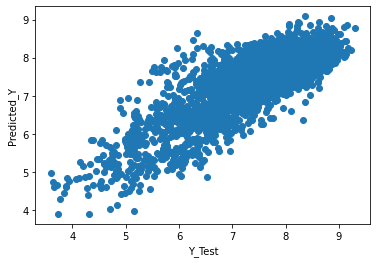

In [86]:
plt.scatter(x=y_test,y=pred)
plt.xlabel('Y_Test')
plt.ylabel('Predicted_Y')

<AxesSubplot:>

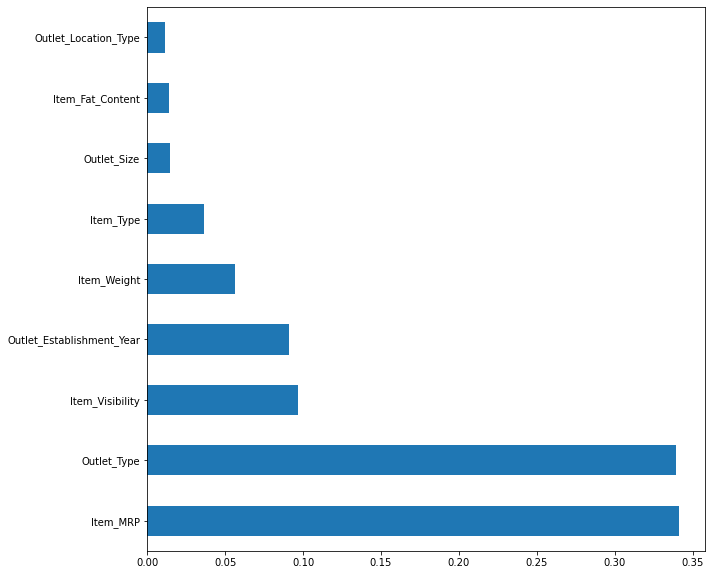

In [87]:
plt.figure(figsize=(10,10))
feat_importances = pd.Series(GBR.feature_importances_, index=X_train.columns)
feat_importances.nlargest(70).plot(kind='barh')

### Pipeline

### Pipeline with 3 features

In [91]:
from sklearn.pipeline import Pipeline,make_pipeline
pipeline_lr=Pipeline([('scalar1',StandardScaler()),
                     ('pca1',PCA(n_components=3)),
                     ('lr_regressor',LinearRegression())])

In [92]:
pipeline_dt=Pipeline([('scalar2',StandardScaler()),
                     ('pca2',PCA(n_components=3)),
                     ('rf_regressor',RandomForestRegressor())])

In [93]:
pipeline_gbr=Pipeline([('scalar2',StandardScaler()),
                     ('pca2',PCA(n_components=3)),
                     ('rf_regressor',GradientBoostingRegressor())])

In [94]:
pipelines = [pipeline_lr, pipeline_dt,pipeline_gbr]

In [95]:
best_accuracy=0.0
best_classifier=0
best_pipeline=""

In [96]:
pipe_dict = {0: 'Linear Regression',1:'RandomForest',2:'GradientBoostingRegressor'}

for pipe in pipelines:
    pipe.fit(X_train, y_train)

In [97]:
pred = pipe.predict(X_test)
r2_scores = r2_score(y_test,pred)
print("R2 Score :",r2_scores*100)

R2 Score : 42.85006825598063


In [98]:
tes = df.iloc[8522:]

In [99]:
test_da = tes.drop(['Item_Outlet_Sales'],axis=1)

In [100]:
for i in test_da.columns:
    scaler = StandardScaler()
    test_da[i] = scaler.fit_transform(test_da[i].values.reshape(-1, 1))

In [102]:
test_da.head()

Item_Weight  Item_Fat_Content  Item_Visibility  Item_Type  Item_MRP  \
8522  0.491743    -0.495532         -0.396923         1.603453  -1.060520   
8523  1.893494    -0.495532         -1.173070         1.366445  -0.536363   
8524 -1.039582     2.903547         -0.529098        -0.766626  -0.868741   
8525  0.444625    -0.495532          0.692108         0.892429   1.630016   
8526 -1.271636    -0.495532         -1.007979         1.366445   0.226882   

      Outlet_Establishment_Year  Outlet_Size  Outlet_Location_Type  \
8522 -0.655438                   1.380812    -1.368869               
8523  0.077167                  -0.284957    -1.368869               
8524  1.176075                  -0.284957    -0.138576               
8525 -0.289135                  -0.284957     1.091717               
8526  1.176075                  -0.284957    -0.138576               

      Outlet_Type  
8522 -0.088929     
8523 -0.088929     
8524 -0.088929     
8525 -2.006500     
8526 -0.088929

In [103]:
GBR = GradientBoostingRegressor()
GBR.fit(X_train,y_train)
pred = GBR.predict(test_da)


In [104]:
pred.shape

(5682,)

In [105]:
SalePrice = pd.DataFrame(pred).reset_index()

In [106]:
Test = pd.DataFrame(test_da).reset_index()

In [107]:
Sale_Price = pd.concat([Test,SalePrice],axis=1)
Sale_Price

index  Item_Weight  Item_Fat_Content  Item_Visibility  Item_Type  \
0     8522   0.491743    -0.495532         -0.396923         1.603453    
1     8523   1.893494    -0.495532         -1.173070         1.366445    
2     8524  -1.039582     2.903547         -0.529098        -0.766626    
3     8525   0.444625    -0.495532          0.692108         0.892429    
4     8526  -1.271636    -0.495532         -1.007979         1.366445    
5     8527   0.018883     1.008585          1.058232        -0.766626    
6     8528  -0.686199     1.008585         -0.013520        -0.292610    
7     8529   1.563670     1.008585          0.360069        -1.714657    
8     8530   0.018883    -0.495532         -0.999696        -1.714657    
9     8531  -1.509581     1.008585          1.148980         1.366445    
10    8532  -1.584969    -0.495532         -1.212643        -1.714657    
11    8533   0.915802    -0.495532          0.769498        -0.292610    
12    8534  -1.442438    -0.495532          0.812824        -0.292610    
13    8535   0.018883    -0.495532          2.036812         0.181406    
14    8536  -1.867675    -0.495532          0.558975        -1.477649    
15    8537   0.951140    -3.066835         -0.886030        -0.055602    
16    8538  -1.549631     1.008585          0.297859        -1.714657    
17    8539   1.681464    -0.495532         -0.208663         1.129437    
18    8540   1.210288    -0.495532         -0.538282         1.603453    
19    8541   0.018883    -0.495532         -0.740684         0.418414    
20    8542   0.209037    -0.495532          2.502260         1.366445    
21    8543  -1.322288    -0.495532          0.891980        -0.292610    
22    8544   1.528332    -0.495532          2.246108         0.892429    
23    8545   0.220816    -3.066835          0.022837        -0.529618    
24    8546   0.018883    -0.495532         -0.755995         0.892429    
25    8547   1.528332    -0.495532         -0.595977         1.366445    
26    8548  -1.396498     1.008585         -0.528534         1.366445    
27    8549   0.067684    -0.495532         -0.597562         0.418414    
28    8550  -1.622663    -0.495532          0.534499         0.418414    
29    8551   0.256154    -0.495532         -0.128486        -0.766626    
30    8552   0.020566    -3.066835         -0.849822        -0.292610    
31    8553   0.018883    -0.495532          0.057778         0.418414    
32    8554  -0.756876     1.008585         -0.866348         0.655421    
33    8555  -0.050110    -0.495532         -1.189432         0.418414    
34    8556   0.018883     1.008585         -0.809596        -0.292610    
35    8557  -1.633265    -0.495532          0.640734        -1.477649    
36    8558   0.018883     1.008585         -1.149171         0.655421    
37    8559   0.018883    -0.495532          0.288179        -1.003634    
38    8560  -0.546024    -0.495532         -0.282812        -1.714657    
39    8561   1.328082    -0.495532          0.495367         0.418414    
40    8562   0.018883    -0.495532         -0.996337         0.418414    
41    8563   1.975950    -0.495532         -0.721123         0.418414    
42    8564   1.657906    -3.066835          0.094932        -0.292610    
43    8565  -1.008955    -0.495532          2.175256         0.418414    
44    8566   0.621317    -0.495532         -1.000587         0.892429    
45    8567  -1.414167    -0.495532         -0.099003        -1.477649    
46    8568  -0.593142    -0.495532          1.204245        -1.003634    
47    8569  -0.250361    -0.495532          4.122978        -0.766626    
48    8570   0.032345    -0.495532         -0.222868         0.181406    
49    8571  -0.132566    -0.495532          1.296470        -0.529618    
50    8572   1.304523    -0.495532          0.213544         1.366445    
51    8573  -1.586147    -0.495532          0.220749        -0.055602    
52    8574  -0.014772    -0.495532          1.140675         0.655421    
53    8575